In [1]:
# If you're on Colab or a fresh env, uncomment the next line:
# !pip install -q tensorflow==2.* numpy pandas scikit-learn matplotlib

import os, json, random, itertools, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split


In [2]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Output paths
RUN_TS = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
ART_DIR = f"artifacts_{RUN_TS}"
os.makedirs(ART_DIR, exist_ok=True)

def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)


In [3]:
NUM_WORDS = 10_000  # vocabulary size

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def vectorize(seqs, dim=NUM_WORDS):
    arr = np.zeros((len(seqs), dim), dtype="float32")
    for i, s in enumerate(seqs):
        arr[i, s] = 1.0
    return arr

X_train = vectorize(x_train)
X_test  = vectorize(x_test)
y_train = np.array(y_train, dtype="float32")
y_test  = np.array(y_test,  dtype="float32")

# fixed, stratified train/val split (keep stable for fair A/B comparisons)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=SEED, stratify=y_train
)

len(X_tr), len(X_val), len(X_test)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(20000, 5000, 25000)

In [4]:
def make_mlp(hidden_layers=2, units=64, activation="relu",
             loss="binary_crossentropy", dropout=0.0, l2=0.0, lr=1e-3):
    inputs = keras.Input(shape=(NUM_WORDS,))
    x = inputs
    for _ in range(hidden_layers):
        x = layers.Dense(
            units,
            activation=activation,
            kernel_regularizer=regularizers.l2(l2) if l2 > 0 else None,
        )(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    # Binary sentiment → sigmoid
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=loss,
        metrics=["accuracy"]
    )
    return model


In [5]:
HIDDEN_LAYERS = [1, 2, 3]                # requirement #1
UNITS         = [32, 64]                 # requirement #2 (includes 32 & 64)
LOSSES        = ["binary_crossentropy", "mse"]     # requirement #3
ACTIVATIONS   = ["relu", "tanh"]         # requirement #4

# Regularization options (requirement #5)
REGS = [
    {"dropout": 0.0, "l2": 0.0},
    {"dropout": 0.3, "l2": 0.0},
    {"dropout": 0.5, "l2": 0.0},
    {"dropout": 0.0, "l2": 1e-4},  # L2 only
]

EPOCHS = 20
BATCH  = 512

def config_name(hl, u, act, loss, do, l2):
    return f"HL{hl}_U{u}_{act}_{loss}_do{do}_l2{l2}"


In [6]:
results = []

for hl, u, loss, act, reg in itertools.product(HIDDEN_LAYERS, UNITS, LOSSES, ACTIVATIONS, REGS):
    do, l2 = reg["dropout"], reg["l2"]
    # Skip the "too heavy" combo of using both big dropout and L2 simultaneously (we already cover each alone)
    if do > 0 and l2 > 0:
        continue

    name = config_name(hl, u, act, loss, do, l2)
    print(f"\n=== Training {name} ===")

    model = make_mlp(hidden_layers=hl, units=u, activation=act, loss=loss, dropout=do, l2=l2)

    ckpt_path = os.path.join(ART_DIR, f"{name}.keras")
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max", save_best_only=True),
    ]

    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=0,
        callbacks=callbacks
    )

    # Evaluate with restored best weights
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Save history for plotting/report
    with open(os.path.join(ART_DIR, f"{name}_history.json"), "w") as f:
        json.dump(hist.history, f)

    results.append({
        "name": name,
        "hidden_layers": hl,
        "units": u,
        "activation": act,
        "loss": loss,
        "dropout": float(do),
        "l2": float(l2),
        "epochs_trained": int(len(hist.history["loss"])),
        "val_accuracy": float(val_acc),
        "val_loss": float(val_loss),
        "test_accuracy": float(test_acc),
        "test_loss": float(test_loss),
        "checkpoint": ckpt_path
    })

    # free graph memory between runs
    K.clear_session()

len(results)



=== Training HL1_U32_relu_binary_crossentropy_do0.0_l20.0 ===

=== Training HL1_U32_relu_binary_crossentropy_do0.3_l20.0 ===

=== Training HL1_U32_relu_binary_crossentropy_do0.5_l20.0 ===

=== Training HL1_U32_relu_binary_crossentropy_do0.0_l20.0001 ===

=== Training HL1_U32_tanh_binary_crossentropy_do0.0_l20.0 ===

=== Training HL1_U32_tanh_binary_crossentropy_do0.3_l20.0 ===

=== Training HL1_U32_tanh_binary_crossentropy_do0.5_l20.0 ===

=== Training HL1_U32_tanh_binary_crossentropy_do0.0_l20.0001 ===

=== Training HL1_U32_relu_mse_do0.0_l20.0 ===

=== Training HL1_U32_relu_mse_do0.3_l20.0 ===

=== Training HL1_U32_relu_mse_do0.5_l20.0 ===

=== Training HL1_U32_relu_mse_do0.0_l20.0001 ===

=== Training HL1_U32_tanh_mse_do0.0_l20.0 ===

=== Training HL1_U32_tanh_mse_do0.3_l20.0 ===

=== Training HL1_U32_tanh_mse_do0.5_l20.0 ===

=== Training HL1_U32_tanh_mse_do0.0_l20.0001 ===

=== Training HL1_U64_relu_binary_crossentropy_do0.0_l20.0 ===

=== Training HL1_U64_relu_binary_crossentrop

96

In [7]:
df = pd.DataFrame(results)
df_sorted_val  = df.sort_values(["val_accuracy","test_accuracy"], ascending=False)
df_sorted_test = df.sort_values(["test_accuracy","val_accuracy"], ascending=False)

csv_path = os.path.join(ART_DIR, "results_assignment2.csv")
json_path = os.path.join(ART_DIR, "leaderboard.json")
df.to_csv(csv_path, index=False)
save_json(df_sorted_val.head(25).to_dict(orient="records"), json_path)

print("Saved:", csv_path)
print("Top 10 by Validation Accuracy")
display(df_sorted_val.head(10)[["name","val_accuracy","test_accuracy","epochs_trained"]])

print("Top 10 by Test Accuracy")
display(df_sorted_test.head(10)[["name","val_accuracy","test_accuracy","epochs_trained"]])


Saved: artifacts_20251013_213131/results_assignment2.csv
Top 10 by Validation Accuracy


,name,val_accuracy,test_accuracy,epochs_trained
18,HL1_U64_relu_binary_crossentropy_do0.5_l20.0,0.8932,0.88888,6
10,HL1_U32_relu_mse_do0.5_l20.0,0.8914,0.88936,7
17,HL1_U64_relu_binary_crossentropy_do0.3_l20.0,0.8914,0.88652,5
38,HL2_U32_tanh_binary_crossentropy_do0.5_l20.0,0.8914,0.88648,5
2,HL1_U32_relu_binary_crossentropy_do0.5_l20.0,0.8912,0.88780,7
37,HL2_U32_tanh_binary_crossentropy_do0.3_l20.0,0.8910,0.88592,5
54,HL2_U64_tanh_binary_crossentropy_do0.5_l20.0,0.8904,0.88632,5
26,HL1_U64_relu_mse_do0.5_l20.0,0.8902,0.88880,6
5,HL1_U32_tanh_binary_crossentropy_do0.3_l20.0,0.8900,0.88632,6
33,HL2_U32_relu_binary_crossentropy_do0.3_l20.0,0.8898,0.88600,5


Top 10 by Test Accuracy


,name,val_accuracy,test_accuracy,epochs_trained
10,HL1_U32_relu_mse_do0.5_l20.0,0.8914,0.88936,7
18,HL1_U64_relu_binary_crossentropy_do0.5_l20.0,0.8932,0.88888,6
26,HL1_U64_relu_mse_do0.5_l20.0,0.8902,0.88880,6
6,HL1_U32_tanh_binary_crossentropy_do0.5_l20.0,0.8888,0.88792,6
2,HL1_U32_relu_binary_crossentropy_do0.5_l20.0,0.8912,0.88780,7
57,HL2_U64_relu_mse_do0.3_l20.0,0.8876,0.88752,5
25,HL1_U64_relu_mse_do0.3_l20.0,0.8888,0.88748,5
81,HL3_U64_relu_binary_crossentropy_do0.3_l20.0,0.8890,0.88744,5
11,HL1_U32_relu_mse_do0.0_l20.0001,0.8884,0.88728,5
30,HL1_U64_tanh_mse_do0.5_l20.0,0.8886,0.88712,5


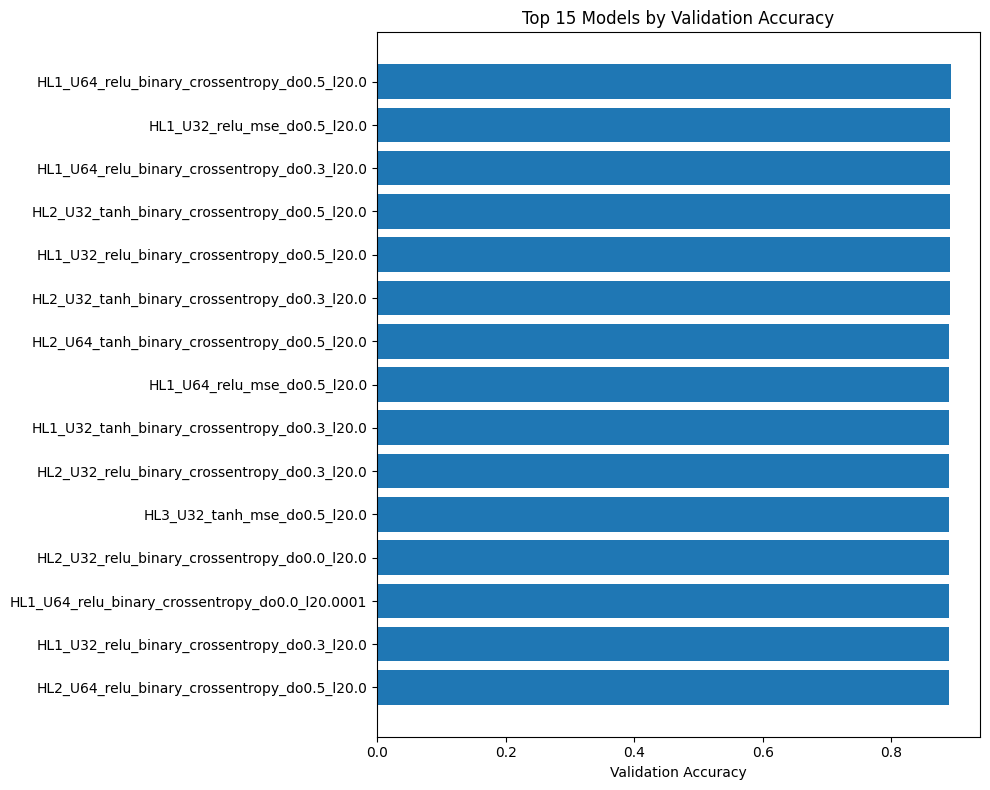

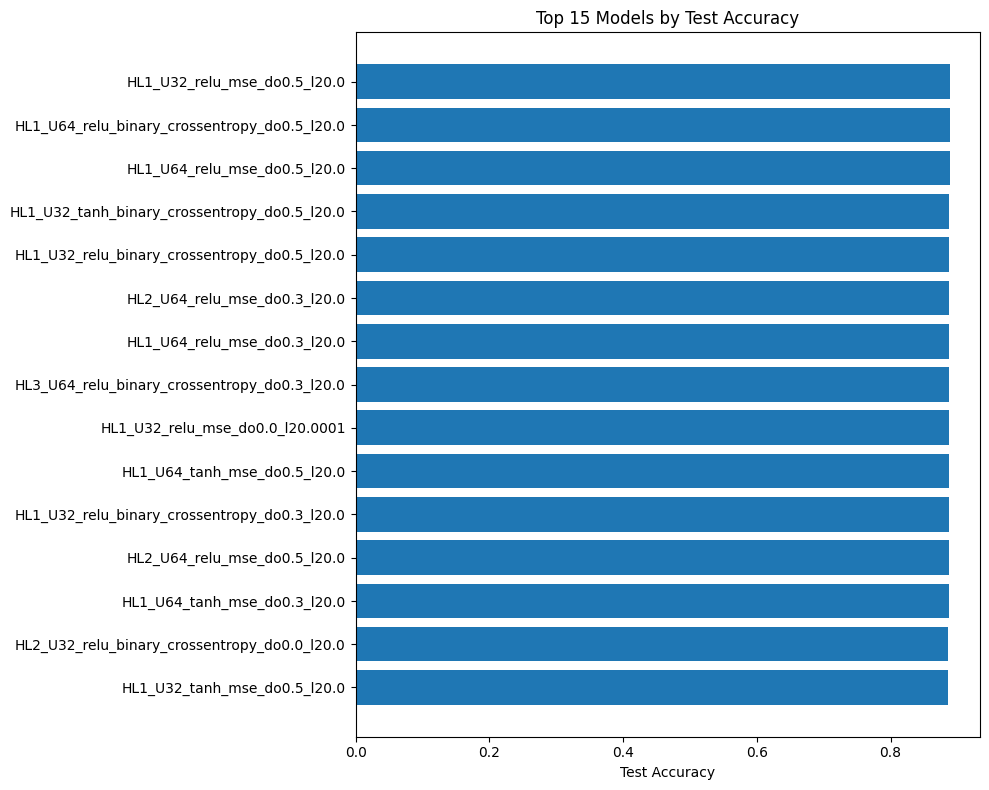

Saved plots: artifacts_20251013_213131/top15_val.png and artifacts_20251013_213131/top15_test.png


In [8]:
# Top-15 by Validation
fig = plt.figure(figsize=(10, 8))
top_val = df_sorted_val.head(15)
plt.barh(top_val["name"], top_val["val_accuracy"])
plt.gca().invert_yaxis()
plt.title("Top 15 Models by Validation Accuracy")
plt.xlabel("Validation Accuracy")
plt.tight_layout()
p1 = os.path.join(ART_DIR, "top15_val.png")
plt.savefig(p1, dpi=200)
plt.show()

# Top-15 by Test
fig = plt.figure(figsize=(10, 8))
top_test = df_sorted_test.head(15)
plt.barh(top_test["name"], top_test["test_accuracy"])
plt.gca().invert_yaxis()
plt.title("Top 15 Models by Test Accuracy")
plt.xlabel("Test Accuracy")
plt.tight_layout()
p2 = os.path.join(ART_DIR, "top15_test.png")
plt.savefig(p2, dpi=200)
plt.show()

print("Saved plots:", p1, "and", p2)


In [9]:
def summarize_factor(df, col):
    s = df.groupby(col)[["val_accuracy","test_accuracy"]].mean().sort_values("val_accuracy", ascending=False)
    return s.round(4)

print("By depth (hidden_layers):")
display(summarize_factor(df, "hidden_layers"))

print("By width (units):")
display(summarize_factor(df, "units"))

print("By activation:")
display(summarize_factor(df, "activation"))

print("By loss:")
display(summarize_factor(df, "loss"))

print("By dropout:")
display(summarize_factor(df, "dropout"))

print("By L2:")
display(summarize_factor(df, "l2"))


By depth (hidden_layers):


,val_accuracy,test_accuracy
hidden_layers,,
1,0.8882,0.8861
2,0.8866,0.8839
3,0.8842,0.8818


By width (units):


,val_accuracy,test_accuracy
units,,
32,0.8871,0.8846
64,0.8855,0.8832


By activation:


,val_accuracy,test_accuracy
activation,,
relu,0.8871,0.8846
tanh,0.8855,0.8832


By loss:


,val_accuracy,test_accuracy
loss,,
binary_crossentropy,0.8870,0.8840
mse,0.8857,0.8838


By dropout:


,val_accuracy,test_accuracy
dropout,,
0.5,0.8887,0.8863
0.3,0.8873,0.8851
0.0,0.8846,0.8821


By L2:


,val_accuracy,test_accuracy
l2,,
0.0000,0.8869,0.8845
0.0001,0.8846,0.8822


In [10]:
best = df_sorted_val.iloc[0]
print("Best (by val):")
display(best)

# Load the saved best checkpoint and re-evaluate
best_model = keras.models.load_model(best["checkpoint"])
final_test_loss, final_test_acc = best_model.evaluate(X_test, y_test, verbose=0)

summary = {
    "best_name": best["name"],
    "best_val_accuracy": float(best["val_accuracy"]),
    "best_test_accuracy": float(final_test_acc),
    "checkpoint": best["checkpoint"],
}
save_json(summary, os.path.join(ART_DIR, "best_config.json"))
summary


Best (by val):


,18
name,HL1_U64_relu_binary_crossentropy_do0.5_l20.0
hidden_layers,1
units,64
activation,relu
loss,binary_crossentropy
dropout,0.5
l2,0.0
epochs_trained,6
val_accuracy,0.8932
val_loss,0.274806


{'best_name': 'HL1_U64_relu_binary_crossentropy_do0.5_l20.0',
 'best_val_accuracy': 0.8931999802589417,
 'best_test_accuracy': 0.8888800144195557,
 'checkpoint': 'artifacts_20251013_213131/HL1_U64_relu_binary_crossentropy_do0.5_l20.0.keras'}

In [12]:
# Quickly compute AUC for the best model (not used for early stopping).
from sklearn.metrics import roc_auc_score

y_prob = best_model.predict(X_test, batch_size=1024, verbose=0).ravel()
auc = roc_auc_score(y_test, y_prob)
{"test_accuracy": float(final_test_acc), "test_auc": float(auc)}


{'test_accuracy': 0.8888800144195557, 'test_auc': 0.95248616}